In [ ]:
!unzip /content/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: consolidated/autistic/0873.jpg  
  inflating: consolidated/autistic/0874.jpg  
  inflating: consolidated/autistic/0875.jpg  
  inflating: consolidated/autistic/0876.jpg  
  inflating: consolidated/autistic/0877.jpg  
  inflating: consolidated/autistic/0878.jpg  
  inflating: consolidated/autistic/0879.jpg  
  inflating: consolidated/autistic/0880.jpg  
  inflating: consolidated/autistic/0881.jpg  
  inflating: consolidated/autistic/0882.jpg  
  inflating: consolidated/autistic/0883.jpg  
  inflating: consolidated/autistic/0884.jpg  
  inflating: consolidated/autistic/0885.jpg  
  inflating: consolidated/autistic/0886.jpg  
  inflating: consolidated/autistic/0887.jpg  
  inflating: consolidated/autistic/0888.jpg  
  inflating: consolidated/autistic/0889.jpg  
  inflating: consolidated/autistic/0890.jpg  
  inflating: consolidated/autistic/0891.jpg  
  inflating: consolidated/autistic/0892.jpg  
  inflating: consolidated/aut

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls /content

archive.zip					 consolidated  train
autism-2.txt					 kaggle.json   valid
autism-S-224-89.33.h5				 sample_data
autistic-children-facial-data-set-metadata.json  test


In [ ]:
from torch.utils.data import Dataset, DataLoader


In [ ]:
# ------------------------------- Imports -------------------------------
import os                               # Provides tools for interacting with the operating system (folders/files)
from PIL import Image                   # Imports PIL Image for opening and converting image files
import torch                            # Imports PyTorch core library for tensors and GPU support
import torch.nn as nn                   # Imports neural network layers/modules (e.g., Linear, ReLU, Dropout)
import torch.optim as optim             # Imports optimizers (e.g., Adam) and learning-rate schedulers
from torch.utils.data import Dataset, DataLoader, random_split  # Dataset base class, DataLoader, and dataset splitting utility
import torchvision.transforms as transforms   # Common image preprocessing and augmentation transforms
from torchvision.models import resnet18, ResNet18_Weights        # Pretrained ResNet-18 model and its weight enums
from timm.models.vision_transformer import vit_base_patch16_224  # Pretrained Vision Transformer (ViT-B/16) from timm

# ------------------------------- Device configuration -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, otherwise CPU

# ------------------------------- Hyperparameters and constants -------------------------------
num_classes = 7          # Number of emotion categories (FERAC has 7 classes)
batch_size = 32          # Number of samples per mini-batch
learning_rate = 5e-5     # Learning rate (small for stable fine-tuning, especially for ViT)
num_epochs = 25          # Maximum number of training epochs (early stopping can stop sooner)
image_size = 224         # Input image size required by ResNet-18 and ViT-B/16

# ------------------------------- Class order (explicit mapping) -------------------------------
FERAC_CLASSES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]  # Fixed label order matching folder names

# ------------------------------- Image transforms -------------------------------
transform = transforms.Compose([                                     # Chain multiple transforms into one pipeline
    transforms.Resize((image_size, image_size)),                     # Resize images to 224x224 for consistent input size
    transforms.RandomHorizontalFlip(p=0.5),                          # Randomly flip image horizontally (50% chance)
    transforms.RandomRotation(10),                                   # Randomly rotate image up to +/- 10 degrees
    transforms.RandomApply(                                          # Apply the following transform(s) only with probability p
        [transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)],                # Randomly change brightness/contrast/saturation/hue
        p=0.7                                                        # Apply ColorJitter with 70% probability
    ),
    transforms.RandomGrayscale(p=0.1),                               # Convert image to grayscale with 10% probability
    transforms.ToTensor(),                                           # Convert PIL image to PyTorch tensor (C x H x W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],                 # Normalize using ImageNet mean (per channel)
                         std=[0.229, 0.224, 0.225])                  # Normalize using ImageNet std (per channel)
])

# ------------------------------- Custom Dataset class -------------------------------
class FERACDataset(Dataset):                                         # Define a custom dataset class inheriting from torch Dataset
    def __init__(self, root_dir, transform=None):                    # Constructor: takes dataset root folder and transform pipeline
        self.root_dir = root_dir                                     # Store root directory path (e.g., "./consolidated")
        self.transform = transform                                   # Store transforms to apply to each loaded image
        self.samples = []                                            # Initialize empty list to store (filepath, label) pairs

        self.classes = FERAC_CLASSES                                 # Use fixed class list to enforce consistent labels
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}  # Map class name -> numeric index

        for cls_name in self.classes:                                # Loop through each class folder (angry, disgust, ...)
            cls_dir = os.path.join(root_dir, cls_name)               # Build full folder path for the class
            if not os.path.isdir(cls_dir):                           # Check that the class folder exists
                raise FileNotFoundError(f"Missing class folder: {cls_dir}")  # Raise error if folder is missing (prevents silent bugs)

            for fname in os.listdir(cls_dir):                        # Iterate over all files inside the class folder
                fpath = os.path.join(cls_dir, fname)                 # Build full file path for the current file
                if os.path.isfile(fpath) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):  # Keep only image files
                    self.samples.append((fpath, self.class_to_idx[cls_name]))  # Add (path, label) to sample list

    def __len__(self):                                               # Special method returning total number of samples
        return len(self.samples)                                     # Return number of collected (image, label) pairs

    def __getitem__(self, idx):                                      # Special method returning one sample at index idx
        img_path, label = self.samples[idx]                          # Get image path and label from sample list
        image = Image.open(img_path).convert('RGB')                  # Open image file and convert to 3-channel RGB
        if self.transform:                                           # Check if transforms were provided
            image = self.transform(image)                            # Apply transforms (resize, augmentation, normalize)
        return image, label                                          # Return transformed image tensor and numeric label

# ------------------------------- Dataset loading and splitting -------------------------------
dataset_path = './consolidated'                                      # Root folder containing FERAC class subfolders
full_dataset = FERACDataset(root_dir=dataset_path, transform=transform)  # Create dataset instance with transforms

total_size = len(full_dataset)                                       # Total number of images in dataset
train_size = int(0.7 * total_size)                                   # Compute training set size (70%)
val_size = int(0.15 * total_size)                                    # Compute validation set size (15%)
test_size = total_size - train_size - val_size                       # Assign remaining images to test set (ensures exact total)

train_dataset, val_dataset, test_dataset = random_split(             # Split full dataset into train/val/test subsets
    full_dataset,                                                   # Dataset to be split
    [train_size, val_size, test_size],                              # Sizes of each subset
    generator=torch.Generator().manual_seed(42)                      # Fix seed to make the split reproducible
)

train_loader = DataLoader(train_dataset, batch_size=batch_size,      # DataLoader for training subset
                          shuffle=True, num_workers=4,              # Shuffle training data and load in parallel with 4 workers
                          pin_memory=True, persistent_workers=True) # Speed up GPU transfer + keep workers alive

val_loader = DataLoader(val_dataset, batch_size=batch_size,          # DataLoader for validation subset
                        shuffle=False, num_workers=4,                # No shuffle for validation
                        pin_memory=True, persistent_workers=True)    # Same performance settings

test_loader = DataLoader(test_dataset, batch_size=batch_size,        # DataLoader for test subset
                         shuffle=False, num_workers=4,               # No shuffle for test evaluation
                         pin_memory=True, persistent_workers=True)   # Same performance settings

# ------------------------------- Hybrid CNN–ViT model definition -------------------------------
class FER_ViT(nn.Module):                                            # Define hybrid model class inheriting from nn.Module
    def __init__(self, num_classes=num_classes):                     # Constructor: takes number of classes (7)
        super(FER_ViT, self).__init__()                               # Initialize parent nn.Module

        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)    # Load ResNet-18 pretrained on ImageNet
        self.backbone.fc = nn.Identity()                              # Replace final FC layer with Identity -> output is 512-d feature vector

        self.vit = vit_base_patch16_224(pretrained=True)              # Load ViT-B/16 pretrained (outputs 768-d embeddings)

        for name, param in self.backbone.named_parameters():          # Loop over ResNet parameters with names
            param.requires_grad = False                               # Freeze all ResNet layers by default
            if 'layer3' in name or 'layer4' in name:                  # If parameter belongs to deeper layers
                param.requires_grad = True                            # Unfreeze layer3 and layer4 for fine-tuning

        for param in self.vit.parameters():                           # Loop through all ViT parameters
            param.requires_grad = True                                # Enable training for all ViT parameters

        self.feature_fusion = nn.Sequential(                          # Define fusion module as a sequential stack
            nn.Linear(512 + 768, 512),                                # Project concatenated features (1280) down to 512
            nn.BatchNorm1d(512),                                      # BatchNorm for stable feature scaling
            nn.ReLU()                                                 # ReLU activation to add nonlinearity
        )

        self.classifier = nn.Sequential(                              # Define classifier head as a sequential stack
            nn.Dropout(0.4),                                          # Dropout to reduce overfitting during training
            nn.Linear(512, num_classes)                               # Final linear layer producing logits for 7 classes
        )

    def forward(self, x):                                             # Forward pass: defines how input flows through the model
        local_features = self.backbone(x)                             # ResNet extracts local features -> shape (B, 512)

        vit_out = self.vit.forward_features(x)                        # Extract ViT features (shape may vary by timm version)
        if vit_out.ndim == 3:                                         # If output has tokens dimension: (B, T, 768)
            vit_class_token = vit_out[:, 0, :]                        # Take CLS token -> (B, 768)
        else:                                                         # Otherwise output is already pooled: (B, 768)
            vit_class_token = vit_out                                 # Use it directly as global feature vector

        combined_features = torch.cat((local_features, vit_class_token), dim=1)  # Concatenate -> (B, 1280)
        fused = self.feature_fusion(combined_features)                # Apply fusion module -> (B, 512)
        out = self.classifier(fused)                                  # Apply classifier -> logits (B, 7)
        return out                                                    # Return logits for cross-entropy loss

# ------------------------------- Instantiate model, loss, optimizer, scheduler -------------------------------
model = FER_ViT().to(device)                                          # Create model instance and move it to GPU/CPU device

criterion = nn.CrossEntropyLoss()                                     # Loss for multi-class classification using logits + integer labels

optimizer = optim.Adam(                                               # Create Adam optimizer
    filter(lambda p: p.requires_grad, model.parameters()),            # Only optimize parameters that are trainable
    lr=learning_rate                                                  # Set learning rate
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(                     # Scheduler that reduces LR when val loss plateaus
    optimizer,                                                        # Optimizer to adjust
    mode='min',                                                       # Reduce LR when validation loss stops decreasing
    factor=0.5,                                                       # Multiply LR by 0.5 when plateau detected
    patience=2                                                        # Wait 2 epochs with no improvement before reducing LR
)

# ------------------------------- Training, validation, and test functions -------------------------------
def train():                                                          # Define one full training epoch
    model.train()                                                     # Set model to training mode (enables dropout, BN updates)
    total_loss, correct, total = 0.0, 0, 0                            # Track total loss, correct predictions, total samples

    for images, labels in train_loader:                               # Loop over all training batches
        images, labels = images.to(device), labels.to(device)         # Move batch tensors to GPU/CPU

        outputs = model(images)                                       # Forward pass: compute logits
        loss = criterion(outputs, labels)                             # Compute cross-entropy loss

        optimizer.zero_grad()                                         # Clear previous gradients
        loss.backward()                                               # Backpropagate to compute new gradients
        optimizer.step()                                              # Update trainable parameters

        total_loss += loss.item() * images.size(0)                    # Accumulate loss weighted by batch size
        predicted = outputs.argmax(1)                                 # Predicted class indices from logits
        total += labels.size(0)                                       # Update number of processed samples
        correct += predicted.eq(labels).sum().item()                  # Count correct predictions in this batch

    avg_loss = total_loss / total                                     # Compute average loss over all samples
    accuracy = 100.0 * correct / total                                # Compute accuracy percentage
    return avg_loss, accuracy                                         # Return epoch loss and accuracy


def validate():                                                       # Define validation evaluation (no training)
    model.eval()                                                      # Set model to evaluation mode (disables dropout, fixes BN)
    total_loss, correct, total = 0.0, 0, 0                            # Track validation loss and accuracy stats

    with torch.no_grad():                                             # Disable gradient computation for speed/memory savings
        for images, labels in val_loader:                             # Loop over validation batches
            images, labels = images.to(device), labels.to(device)     # Move batch tensors to GPU/CPU

            outputs = model(images)                                   # Forward pass
            loss = criterion(outputs, labels)                         # Compute loss

            total_loss += loss.item() * images.size(0)                # Accumulate loss
            predicted = outputs.argmax(1)                             # Get predicted labels
            total += labels.size(0)                                   # Update total count
            correct += predicted.eq(labels).sum().item()              # Update correct predictions

    avg_loss = total_loss / total                                     # Compute mean validation loss
    accuracy = 100.0 * correct / total                                # Compute validation accuracy
    return avg_loss, accuracy                                         # Return validation loss and accuracy


def test():                                                           # Define final test evaluation
    model.eval()                                                      # Set evaluation mode
    total_loss, correct, total = 0.0, 0, 0                            # Track test loss and accuracy

    with torch.no_grad():                                             # Disable gradients
        for images, labels in test_loader:                            # Loop over test batches
            images, labels = images.to(device), labels.to(device)     # Move batch to device

            outputs = model(images)                                   # Forward pass
            loss = criterion(outputs, labels)                         # Compute loss

            total_loss += loss.item() * images.size(0)                # Accumulate test loss
            predicted = outputs.argmax(1)                             # Predicted class indices
            total += labels.size(0)                                   # Total test samples processed
            correct += predicted.eq(labels).sum().item()              # Count correct predictions

    avg_loss = total_loss / total                                     # Mean test loss
    accuracy = 100.0 * correct / total                                # Test accuracy percentage
    return avg_loss, accuracy                                         # Return test loss and accuracy

# ------------------------------- Training loop with early stopping -------------------------------
patience = 10                                                         # Number of epochs to wait with no improvement before stopping
best_val_loss = float('inf')                                          # Initialize best validation loss to infinity
best_val_acc = 0.0                                                    # Track validation accuracy at best loss
best_epoch = -1                                                       # Track which epoch produced best loss
epochs_no_improve = 0                                                 # Counter for consecutive epochs without improvement

for epoch in range(num_epochs):                                       # Loop over epochs
    train_loss, train_acc = train()                                   # Run one training epoch
    val_loss, val_acc = validate()                                    # Evaluate on validation set

    scheduler.step(val_loss)                                          # Update LR scheduler based on validation loss

    if val_loss < best_val_loss - 1e-4:                               # If validation loss improved beyond tiny threshold
        best_val_loss = val_loss                                      # Update best validation loss
        best_val_acc = val_acc                                        # Save corresponding validation accuracy
        best_epoch = epoch + 1                                        # Save epoch number (1-indexed)
        epochs_no_improve = 0                                         # Reset no-improvement counter
        torch.save(model.state_dict(), 'fer_vit_best.pth')            # Save best model checkpoint (renamed safely)
    else:                                                             # If no improvement
        epochs_no_improve += 1                                        # Increase no-improvement counter

    print(f"Epoch [{epoch+1}/{num_epochs}] "                          # Print epoch number
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% " # Print training loss/acc
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}% "        # Print validation loss/acc
          f"(no improve: {epochs_no_improve})")                       # Print early-stopping counter status

    if epochs_no_improve >= patience:                                 # Check if early stopping condition met
        print(f"\nEarly stopping triggered at epoch {epoch+1}")       # Inform user early stopping occurred
        break                                                        # Stop training loop

print(f"\nBest validation loss: {best_val_loss:.4f} "                 # Print best validation loss
      f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")  # Print best val accuracy and epoch

# ------------------------------- Final test evaluation using best model -------------------------------
model.load_state_dict(torch.load('fer_vit_best.pth', map_location=device))  # Load best model checkpoint weights
test_loss, test_acc = test()                                         # Evaluate best model on test set
print(f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.2f}%")        # Print final test loss and accuracy


FileNotFoundError: Missing class folder: ./consolidated/angry

In [ ]:
# ------------------------------- Imports -------------------------------
import os                               # Provides tools for interacting with the operating system (folders/files)
from PIL import Image                   # Imports PIL Image for opening and converting image files
import torch                            # Imports PyTorch core library for tensors and GPU support
import torch.nn as nn                   # Imports neural network layers/modules (e.g., Linear, ReLU, Dropout)
import torch.optim as optim             # Imports optimizers (e.g., Adam) and learning-rate schedulers
from torch.utils.data import Dataset, DataLoader, random_split  # Dataset base class, DataLoader, and dataset splitting utility
import torchvision.transforms as transforms   # Common image preprocessing and augmentation transforms
from torchvision.models import resnet18, ResNet18_Weights        # Pretrained ResNet-18 model and its weight enums
from timm.models.vision_transformer import vit_base_patch16_224  # Pretrained Vision Transformer (ViT-B/16) from timm

# ------------------------------- Device configuration -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, otherwise CPU

# ------------------------------- Hyperparameters and constants -------------------------------
num_classes = 7          # Number of emotion categories (FERAC has 7 classes)
batch_size = 32          # Number of samples per mini-batch
learning_rate = 5e-5     # Learning rate (small for stable fine-tuning, especially for ViT)
num_epochs = 25          # Maximum number of training epochs (early stopping can stop sooner)
image_size = 224         # Input image size required by ResNet-18 and ViT-B/16

# ------------------------------- Class order (explicit mapping) -------------------------------
FERAC_CLASSES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]  # Fixed label order matching folder names

# ------------------------------- Image transforms -------------------------------
transform = transforms.Compose([                                     # Chain multiple transforms into one pipeline
    transforms.Resize((image_size, image_size)),                     # Resize images to 224x224 for consistent input size
    transforms.RandomHorizontalFlip(p=0.5),                          # Randomly flip image horizontally (50% chance)
    transforms.RandomRotation(10),                                   # Randomly rotate image up to +/- 10 degrees
    transforms.RandomApply(                                          # Apply the following transform(s) only with probability p
        [transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)],                # Randomly change brightness/contrast/saturation/hue
        p=0.7                                                        # Apply ColorJitter with 70% probability
    ),
    transforms.RandomGrayscale(p=0.1),                               # Convert image to grayscale with 10% probability
    transforms.ToTensor(),                                           # Convert PIL image to PyTorch tensor (C x H x W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],                 # Normalize using ImageNet mean (per channel)
                         std=[0.229, 0.224, 0.225])                  # Normalize using ImageNet std (per channel)
])

# ------------------------------- Custom Dataset class -------------------------------
class FERACDataset(Dataset):                                         # Define a custom dataset class inheriting from torch Dataset
    def __init__(self, root_dir, transform=None):                    # Constructor: takes dataset root folder and transform pipeline
        self.root_dir = root_dir                                     # Store root directory path (e.g., "./consolidated")
        self.transform = transform                                   # Store transforms to apply to each loaded image
        self.samples = []                                            # Initialize empty list to store (filepath, label) pairs

        self.classes = FERAC_CLASSES                                 # Use fixed class list to enforce consistent labels
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}  # Map class name -> numeric index

        for cls_name in self.classes:                                # Loop through each class folder (angry, disgust, ...)
            cls_dir = os.path.join(root_dir, cls_name)               # Build full folder path for the class
            if not os.path.isdir(cls_dir):                           # Check that the class folder exists
                raise FileNotFoundError(f"Missing class folder: {cls_dir}")  # Raise error if folder is missing (prevents silent bugs)

            for fname in os.listdir(cls_dir):                        # Iterate over all files inside the class folder
                fpath = os.path.join(cls_dir, fname)                 # Build full file path for the current file
                if os.path.isfile(fpath) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):  # Keep only image files
                    self.samples.append((fpath, self.class_to_idx[cls_name]))  # Add (path, label) to sample list

    def __len__(self):                                               # Special method returning total number of samples
        return len(self.samples)                                     # Return number of collected (image, label) pairs

    def __getitem__(self, idx):                                      # Special method returning one sample at index idx
        img_path, label = self.samples[idx]                          # Get image path and label from sample list
        image = Image.open(img_path).convert('RGB')                  # Open image file and convert to 3-channel RGB
        if self.transform:                                           # Check if transforms were provided
            image = self.transform(image)                            # Apply transforms (resize, augmentation, normalize)
        return image, label                                          # Return transformed image tensor and numeric label

# ------------------------------- Dataset loading and splitting -------------------------------
dataset_path = './consolidated'                                      # Root folder containing FERAC class subfolders
full_dataset = FERACDataset(root_dir=dataset_path, transform=transform)  # Create dataset instance with transforms

total_size = len(full_dataset)                                       # Total number of images in dataset
train_size = int(0.7 * total_size)                                   # Compute training set size (70%)
val_size = int(0.15 * total_size)                                    # Compute validation set size (15%)
test_size = total_size - train_size - val_size                       # Assign remaining images to test set (ensures exact total)

train_dataset, val_dataset, test_dataset = random_split(             # Split full dataset into train/val/test subsets
    full_dataset,                                                   # Dataset to be split
    [train_size, val_size, test_size],                              # Sizes of each subset
    generator=torch.Generator().manual_seed(42)                      # Fix seed to make the split reproducible
)

train_loader = DataLoader(train_dataset, batch_size=batch_size,      # DataLoader for training subset
                          shuffle=True, num_workers=4,              # Shuffle training data and load in parallel with 4 workers
                          pin_memory=True, persistent_workers=True) # Speed up GPU transfer + keep workers alive

val_loader = DataLoader(val_dataset, batch_size=batch_size,          # DataLoader for validation subset
                        shuffle=False, num_workers=4,                # No shuffle for validation
                        pin_memory=True, persistent_workers=True)    # Same performance settings

test_loader = DataLoader(test_dataset, batch_size=batch_size,        # DataLoader for test subset
                         shuffle=False, num_workers=4,               # No shuffle for test evaluation
                         pin_memory=True, persistent_workers=True)   # Same performance settings

# ------------------------------- Hybrid CNN–ViT model definition -------------------------------
class FER_ViT(nn.Module):                                            # Define hybrid model class inheriting from nn.Module
    def __init__(self, num_classes=num_classes):                     # Constructor: takes number of classes (7)
        super(FER_ViT, self).__init__()                               # Initialize parent nn.Module

        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)    # Load ResNet-18 pretrained on ImageNet
        self.backbone.fc = nn.Identity()                              # Replace final FC layer with Identity -> output is 512-d feature vector

        self.vit = vit_base_patch16_224(pretrained=True)              # Load ViT-B/16 pretrained (outputs 768-d embeddings)

        for name, param in self.backbone.named_parameters():          # Loop over ResNet parameters with names
            param.requires_grad = False                               # Freeze all ResNet layers by default
            if 'layer3' in name or 'layer4' in name:                  # If parameter belongs to deeper layers
                param.requires_grad = True                            # Unfreeze layer3 and layer4 for fine-tuning

        for param in self.vit.parameters():                           # Loop through all ViT parameters
            param.requires_grad = True                                # Enable training for all ViT parameters

        self.feature_fusion = nn.Sequential(                          # Define fusion module as a sequential stack
            nn.Linear(512 + 768, 512),                                # Project concatenated features (1280) down to 512
            nn.BatchNorm1d(512),                                      # BatchNorm for stable feature scaling
            nn.ReLU()                                                 # ReLU activation to add nonlinearity
        )

        self.classifier = nn.Sequential(                              # Define classifier head as a sequential stack
            nn.Dropout(0.4),                                          # Dropout to reduce overfitting during training
            nn.Linear(512, num_classes)                               # Final linear layer producing logits for 7 classes
        )

    def forward(self, x):                                             # Forward pass: defines how input flows through the model
        local_features = self.backbone(x)                             # ResNet extracts local features -> shape (B, 512)

        vit_out = self.vit.forward_features(x)                        # Extract ViT features (shape may vary by timm version)
        if vit_out.ndim == 3:                                         # If output has tokens dimension: (B, T, 768)
            vit_class_token = vit_out[:, 0, :]                        # Take CLS token -> (B, 768)
        else:                                                         # Otherwise output is already pooled: (B, 768)
            vit_class_token = vit_out                                 # Use it directly as global feature vector

        combined_features = torch.cat((local_features, vit_class_token), dim=1)  # Concatenate -> (B, 1280)
        fused = self.feature_fusion(combined_features)                # Apply fusion module -> (B, 512)
        out = self.classifier(fused)                                  # Apply classifier -> logits (B, 7)
        return out                                                    # Return logits for cross-entropy loss

# ------------------------------- Instantiate model, loss, optimizer, scheduler -------------------------------
model = FER_ViT().to(device)                                          # Create model instance and move it to GPU/CPU device

criterion = nn.CrossEntropyLoss()                                     # Loss for multi-class classification using logits + integer labels

optimizer = optim.Adam(                                               # Create Adam optimizer
    filter(lambda p: p.requires_grad, model.parameters()),            # Only optimize parameters that are trainable
    lr=learning_rate                                                  # Set learning rate
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(                     # Scheduler that reduces LR when val loss plateaus
    optimizer,                                                        # Optimizer to adjust
    mode='min',                                                       # Reduce LR when validation loss stops decreasing
    factor=0.5,                                                       # Multiply LR by 0.5 when plateau detected
    patience=2                                                        # Wait 2 epochs with no improvement before reducing LR
)

# ------------------------------- Training, validation, and test functions -------------------------------
def train():                                                          # Define one full training epoch
    model.train()                                                     # Set model to training mode (enables dropout, BN updates)
    total_loss, correct, total = 0.0, 0, 0                            # Track total loss, correct predictions, total samples

    for images, labels in train_loader:                               # Loop over all training batches
        images, labels = images.to(device), labels.to(device)         # Move batch tensors to GPU/CPU

        outputs = model(images)                                       # Forward pass: compute logits
        loss = criterion(outputs, labels)                             # Compute cross-entropy loss

        optimizer.zero_grad()                                         # Clear previous gradients
        loss.backward()                                               # Backpropagate to compute new gradients
        optimizer.step()                                              # Update trainable parameters

        total_loss += loss.item() * images.size(0)                    # Accumulate loss weighted by batch size
        predicted = outputs.argmax(1)                                 # Predicted class indices from logits
        total += labels.size(0)                                       # Update number of processed samples
        correct += predicted.eq(labels).sum().item()                  # Count correct predictions in this batch

    avg_loss = total_loss / total                                     # Compute average loss over all samples
    accuracy = 100.0 * correct / total                                # Compute accuracy percentage
    return avg_loss, accuracy                                         # Return epoch loss and accuracy


def validate():                                                       # Define validation evaluation (no training)
    model.eval()                                                      # Set model to evaluation mode (disables dropout, fixes BN)
    total_loss, correct, total = 0.0, 0, 0                            # Track validation loss and accuracy stats

    with torch.no_grad():                                             # Disable gradient computation for speed/memory savings
        for images, labels in val_loader:                             # Loop over validation batches
            images, labels = images.to(device), labels.to(device)     # Move batch tensors to GPU/CPU

            outputs = model(images)                                   # Forward pass
            loss = criterion(outputs, labels)                         # Compute loss

            total_loss += loss.item() * images.size(0)                # Accumulate loss
            predicted = outputs.argmax(1)                             # Get predicted labels
            total += labels.size(0)                                   # Update total count
            correct += predicted.eq(labels).sum().item()              # Update correct predictions

    avg_loss = total_loss / total                                     # Compute mean validation loss
    accuracy = 100.0 * correct / total                                # Compute validation accuracy
    return avg_loss, accuracy                                         # Return validation loss and accuracy


def test():                                                           # Define final test evaluation
    model.eval()                                                      # Set evaluation mode
    total_loss, correct, total = 0.0, 0, 0                            # Track test loss and accuracy

    with torch.no_grad():                                             # Disable gradients
        for images, labels in test_loader:                            # Loop over test batches
            images, labels = images.to(device), labels.to(device)     # Move batch to device

            outputs = model(images)                                   # Forward pass
            loss = criterion(outputs, labels)                         # Compute loss

            total_loss += loss.item() * images.size(0)                # Accumulate test loss
            predicted = outputs.argmax(1)                             # Predicted class indices
            total += labels.size(0)                                   # Total test samples processed
            correct += predicted.eq(labels).sum().item()              # Count correct predictions

    avg_loss = total_loss / total                                     # Mean test loss
    accuracy = 100.0 * correct / total                                # Test accuracy percentage
    return avg_loss, accuracy                                         # Return test loss and accuracy

# ------------------------------- Training loop with early stopping -------------------------------
patience = 10                                                         # Number of epochs to wait with no improvement before stopping
best_val_loss = float('inf')                                          # Initialize best validation loss to infinity
best_val_acc = 0.0                                                    # Track validation accuracy at best loss
best_epoch = -1                                                       # Track which epoch produced best loss
epochs_no_improve = 0                                                 # Counter for consecutive epochs without improvement

for epoch in range(num_epochs):                                       # Loop over epochs
    train_loss, train_acc = train()                                   # Run one training epoch
    val_loss, val_acc = validate()                                    # Evaluate on validation set

    scheduler.step(val_loss)                                          # Update LR scheduler based on validation loss

    if val_loss < best_val_loss - 1e-4:                               # If validation loss improved beyond tiny threshold
        best_val_loss = val_loss                                      # Update best validation loss
        best_val_acc = val_acc                                        # Save corresponding validation accuracy
        best_epoch = epoch + 1                                        # Save epoch number (1-indexed)
        epochs_no_improve = 0                                         # Reset no-improvement counter
        torch.save(model.state_dict(), 'fer_vit_best.pth')            # Save best model checkpoint (renamed safely)
    else:                                                             # If no improvement
        epochs_no_improve += 1                                        # Increase no-improvement counter

    print(f"Epoch [{epoch+1}/{num_epochs}] "                          # Print epoch number
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% " # Print training loss/acc
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}% "        # Print validation loss/acc
          f"(no improve: {epochs_no_improve})")                       # Print early-stopping counter status

    if epochs_no_improve >= patience:                                 # Check if early stopping condition met
        print(f"\nEarly stopping triggered at epoch {epoch+1}")       # Inform user early stopping occurred
        break                                                        # Stop training loop

print(f"\nBest validation loss: {best_val_loss:.4f} "                 # Print best validation loss
      f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")  # Print best val accuracy and epoch

# ------------------------------- Final test evaluation using best model -------------------------------
model.load_state_dict(torch.load('fer_vit_best.pth', map_location=device))  # Load best model checkpoint weights
test_loss, test_acc = test()                                         # Evaluate best model on test set
print(f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.2f}%")        # Print final test loss and accuracy


In [ ]:
import os                               # For filesystem operations
from PIL import Image                   # For loading images
import torch                            # Core PyTorch
import torch.nn as nn                   # Neural network modules
import torch.optim as optim             # Optimizers
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms   # Image transforms
from torchvision.models import resnet18, ResNet18_Weights  # Pretrained ResNet-18
from timm.models.vision_transformer import vit_base_patch16_224  # Pretrained ViT

# -------------------------------------------------------
# Device configuration
# -------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------------------------------------------
# Hyperparameters and constants
# -------------------------------------------------------
num_classes = 7          # Number of emotion categories
batch_size = 32          # Batch size
learning_rate = 5e-5     # Smaller LR for safer fine-tuning of ViT
num_epochs = 25          # Maximum number of epochs (with early stopping)
image_size = 224         # Input resolution for ResNet and ViT

# -------------------------------------------------------
# Image transforms (stronger augmentation + normalization)
# -------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),      # Standardize spatial size
    transforms.RandomHorizontalFlip(p=0.5),           # Random horizontal flip with 50% chance
    transforms.RandomRotation(10),                    # Small random rotation up to ±10°
    transforms.RandomApply(                           # Apply color jitter only sometimes
        [transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)], # Mild changes in brightness/contrast/saturation/hue
        p=0.7
    ),
    transforms.RandomGrayscale(p=0.1),                # Convert to grayscale with 10% chance
    transforms.ToTensor(),                            # PIL -> tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# -------------------------------------------------------
# Custom Dataset for folder-structured images
# root_dir/
#   class_0/
#   class_1/
#   ...
# -------------------------------------------------------
class AutismFacialDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir          # Root folder for data
        self.transform = transform        # Transform pipeline
        self.samples = []                 # List of (image_path, label) pairs

        # Discover class folders (one per emotion)
        self.classes = sorted(
            entry.name for entry in os.scandir(root_dir) if entry.is_dir()
        )
        # Map class name -> index
        self.class_to_idx = {
            cls_name: idx for idx, cls_name in enumerate(self.classes)
        }

        # Walk through each class folder and collect file paths + labels
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for fname in os.listdir(cls_dir):
                fpath = os.path.join(cls_dir, fname)
                if os.path.isfile(fpath) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((fpath, self.class_to_idx[cls_name]))

    def __len__(self):
        # Total number of images
        return len(self.samples)

    def __getitem__(self, idx):
        # Load one image and its label
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')   # Ensure 3-channel RGB
        if self.transform:
            image = self.transform(image)
        return image, label

# -------------------------------------------------------
# Dataset loading and splitting (70/15/15)
# -------------------------------------------------------
dataset_path = './consolidated'   # Root folder of your dataset
full_dataset = AutismFacialDataset(root_dir=dataset_path, transform=transform)

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # ensure total matches

# Reproducible random split into train/val/test
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4)

# -------------------------------------------------------
# Hybrid CNN–ViT model definition
# -------------------------------------------------------
class FER_ViT(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(FER_ViT, self).__init__()

        # Local feature extractor: ResNet-18 pretrained on ImageNet
        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()       # Remove final FC to keep 512-dim features

        # Global feature extractor: Vision Transformer (ViT-B/16, 224x224)
        self.vit = vit_base_patch16_224(pretrained=True)

        # Freeze all ResNet parameters first
        for name, param in self.backbone.named_parameters():
            param.requires_grad = False
            # Unfreeze deeper blocks (layer3 + layer4) for better adaptation
            if 'layer3' in name or 'layer4' in name:
                param.requires_grad = True

        # Make all ViT parameters trainable for fine-tuning
        for param in self.vit.parameters():
            param.requires_grad = True

        # Fusion layer: concatenate 512-dim ResNet + 768-dim ViT CLS token -> 512-dim
        self.feature_fusion = nn.Sequential(
            nn.Linear(512 + 768, 512),         # 1280 -> 512 projection
            nn.BatchNorm1d(512),               # Normalize features for stability
            nn.ReLU()                          # Non-linear activation
        )

        # Classifier head: stronger dropout to reduce overfitting
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),                   # Drop 40% of units during training
            nn.Linear(512, num_classes)        # Final logits for 7 classes
        )

    def forward(self, x):
        # Local features from ResNet (batch, 512)
        local_features = self.backbone(x)

        # Global features from ViT (tokens); forward_features returns (batch, tokens, 768)
        vit_features = self.vit.forward_features(x)
        # Use the [CLS] token (first token) as global representation (batch, 768)
        vit_class_token = vit_features[:, 0]

        # Concatenate local and global features along feature dimension
        combined_features = torch.cat((local_features, vit_class_token), dim=1)

        # Apply fusion MLP
        fused = self.feature_fusion(combined_features)
        # Classify fused features
        out = self.classifier(fused)
        return out

# -------------------------------------------------------
# Instantiate model, loss, optimizer, scheduler
# -------------------------------------------------------
model = FER_ViT().to(device)

criterion = nn.CrossEntropyLoss()           # Multi-class cross-entropy

# Only update parameters that require gradients (unfrozen)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate
)

# Scheduler that reduces LR when validation loss stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',       # We want to minimize validation loss
    factor=0.5,       # Halve the LR when plateau is detected
    patience=2       # Wait 2 epochs without improvement before reducing LR
)

# -------------------------------------------------------
# Training, validation, and test functions
# -------------------------------------------------------
def train():
    """One epoch of training on train_loader."""
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)                   # Forward pass
        loss = criterion(outputs, labels)         # Compute loss

        optimizer.zero_grad()                     # Clear old gradients
        loss.backward()                           # Backpropagate
        optimizer.step()                          # Update weights

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)             # Predicted class index
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total           # Training accuracy in %
    return avg_loss, accuracy


def validate():
    """Evaluate on val_loader without gradient updates."""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total           # Validation accuracy in %
    return avg_loss, accuracy


def test():
    """Final evaluation on held-out test_loader."""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total           # Test accuracy in %
    return avg_loss, accuracy

# -------------------------------------------------------
# Training loop with early stopping (on validation loss)
# -------------------------------------------------------
patience = 10                        # Stop if no val-loss improvement for this many epochs
best_val_loss = float('inf')         # Best (lowest) validation loss seen so far
best_val_acc = 0.0                   # Validation accuracy at best loss
best_epoch = -1
epochs_no_improve = 0                # Counter for early stopping

for epoch in range(num_epochs):
    train_loss, train_acc = train()
    val_loss, val_acc = validate()

    # Step LR scheduler using validation loss
    scheduler.step(val_loss)

    # Early stopping check on validation loss (with small tolerance to ignore noise)
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        epochs_no_improve = 0
        # Save best model weights
        torch.save(model.state_dict(), 'fer_vit_autism_best.pth')
    else:
        epochs_no_improve += 1

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}% "
          f"(no improve: {epochs_no_improve})")

    # Trigger early stopping
    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print(f"\nBest validation loss: {best_val_loss:.4f} "
      f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")

# -------------------------------------------------------
# Final test evaluation using best model
# -------------------------------------------------------
model.load_state_dict(torch.load('fer_vit_autism_best.pth'))   # Load best checkpoint
test_loss, test_acc = test()
print(f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.2f}%")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/25] Train Loss: 1.0850 Train Acc: 69.73% Val Loss: 0.6395 Val Acc: 81.36% (no improve: 0)
Epoch [2/25] Train Loss: 0.5394 Train Acc: 84.96% Val Loss: 0.6246 Val Acc: 75.00% (no improve: 0)
Epoch [3/25] Train Loss: 0.4031 Train Acc: 87.15% Val Loss: 0.4550 Val Acc: 83.86% (no improve: 0)
Epoch [4/25] Train Loss: 0.3296 Train Acc: 89.83% Val Loss: 0.6270 Val Acc: 76.82% (no improve: 1)
Epoch [5/25] Train Loss: 0.2325 Train Acc: 92.21% Val Loss: 0.5297 Val Acc: 84.55% (no improve: 2)
Epoch [6/25] Train Loss: 0.1826 Train Acc: 93.82% Val Loss: 0.3787 Val Acc: 85.00% (no improve: 0)
Epoch [7/25] Train Loss: 0.1509 Train Acc: 95.09% Val Loss: 0.4772 Val Acc: 82.27% (no improve: 1)
Epoch [8/25] Train Loss: 0.1268 Train Acc: 96.55% Val Loss: 0.3901 Val Acc: 85.68% (no improve: 2)
Epoch [9/25] Train Loss: 0.1270 Train Acc: 96.35% Val Loss: 0.3993 Val Acc: 85.68% (no improve: 3)
Epoch [10/25] Train Loss: 0.0888 Train Acc: 97.42% Val Loss: 0.4207 Val Acc: 86.59% (no improve: 4)
Epoch [11

In [ ]:
import os                           # For filesystem operations
from PIL import Image               # For loading images
import torch                        # Core PyTorch
import torch.nn as nn               # Neural network modules
import torch.optim as optim         # Optimizers
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms   # Image transforms
from torchvision.models import resnet18, ResNet18_Weights  # Pretrained ResNet-18
from timm.models.vision_transformer import vit_base_patch16_224  # Pretrained ViT

# -------------------------------------------------------
# Device configuration
# -------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -------------------------------------------------------
# Hyperparameters and constants
# -------------------------------------------------------
num_classes = 7          # Number of emotion categories
batch_size = 32          # Batch size
learning_rate = 1e-4     # Base learning rate for fine-tuning
num_epochs = 25          # Maximum number of epochs (with early stopping)
image_size = 224         # Input resolution for ResNet and ViT

# -------------------------------------------------------
# Image transforms (augmentation + normalization)
# -------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),       # Standardize spatial size
    transforms.RandomHorizontalFlip(),                 # Random horizontal flip
    transforms.RandomRotation(15),                     # Small random rotation
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),        # Color augmentation
    transforms.ToTensor(),                             # PIL -> tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# -------------------------------------------------------
# Custom Dataset for folder-structured images
# root_dir/
#    class_0/
#    class_1/
#    ...
# -------------------------------------------------------
class AutismFacialDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Discover class folders
        self.classes = sorted(
            entry.name for entry in os.scandir(root_dir) if entry.is_dir()
        )
        self.class_to_idx = {
            cls_name: idx for idx, cls_name in enumerate(self.classes)
        }

        # Collect (image_path, label) pairs
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for fname in os.listdir(cls_dir):
                fpath = os.path.join(cls_dir, fname)
                if os.path.isfile(fpath) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((fpath, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# -------------------------------------------------------
# Dataset loading and splitting (70/15/15)
# -------------------------------------------------------
dataset_path = './consolidated'   # Root folder of your dataset
full_dataset = AutismFacialDataset(root_dir=dataset_path, transform=transform)

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # ensures full coverage

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducible split
)

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4)

# -------------------------------------------------------
# Hybrid CNN–ViT model definition
# -------------------------------------------------------
class FER_ViT(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(FER_ViT, self).__init__()

        # Local feature extractor: ResNet-18 pretrained on ImageNet
        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()  # remove final FC, keep 512-dim features

        # Global feature extractor: Vision Transformer (ViT-B/16, 224x224)
        self.vit = vit_base_patch16_224(pretrained=True)

        # Freeze ResNet except last residual block (layer4) for fine-tuning
        for name, param in self.backbone.named_parameters():
            param.requires_grad = False
            if 'layer4' in name:
                param.requires_grad = True

        # Make all ViT parameters trainable
        for param in self.vit.parameters():
            param.requires_grad = True

        # Fusion layer: concatenate 512-d ResNet + 768-d ViT class token -> 512-d
        self.feature_fusion = nn.Sequential(
            nn.Linear(512 + 768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )

        # Classifier head: dropout + linear to num_classes
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Local features from ResNet (batch, 512)
        local_features = self.backbone(x)

        # Global features from ViT; forward_features returns tokens
        vit_features = self.vit.forward_features(x)
        # Use the [CLS] token (first token) as global representation (batch, 768)
        vit_class_token = vit_features[:, 0]

        # Concatenate local and global features
        combined_features = torch.cat((local_features, vit_class_token), dim=1)

        # Fuse and classify
        fused = self.feature_fusion(combined_features)
        out = self.classifier(fused)
        return out

# -------------------------------------------------------
# Instantiate model, loss, optimizer, scheduler
# -------------------------------------------------------
model = FER_ViT().to(device)

criterion = nn.CrossEntropyLoss()  # can add class weights if needed

# Only update parameters that require gradients (unfrozen)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate
)

# CosineAnnealingLR for smooth learning rate decay
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# -------------------------------------------------------
# Training, validation, and test functions
# -------------------------------------------------------
def train():
    """One epoch of training on train_loader."""
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


def validate():
    """Evaluate on val_loader without gradient updates."""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


def test():
    """Final evaluation on held-out test_loader."""
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

# -------------------------------------------------------
# Training loop with early stopping (on validation loss)
# -------------------------------------------------------
patience = 10                  # stop if no val-loss improvement for this many epochs
best_val_loss = float('inf')  # best (lowest) validation loss seen so far
best_val_acc = 0.0            # validation accuracy at best loss
best_epoch = -1
epochs_no_improve = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train()
    val_loss, val_acc = validate()

    # Step scheduler (use val_loss if you switch to ReduceLROnPlateau)
    scheduler.step()

    # Early stopping check on validation loss (with small delta to avoid noise)
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'fer_vit_autism_best.pth')
    else:
        epochs_no_improve += 1

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}% "
          f"(no improve: {epochs_no_improve})")

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print(f"\nBest validation loss: {best_val_loss:.4f} "
      f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")

# -------------------------------------------------------
# Final test evaluation using best model
# -------------------------------------------------------
model.load_state_dict(torch.load('fer_vit_autism_best.pth'))
test_loss, test_acc = test()
print(f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.2f}%")


Epoch [1/25] Train Loss: 1.0680 Train Acc: 70.80% Val Loss: 0.6801 Val Acc: 77.95% (no improve: 0)
Epoch [2/25] Train Loss: 0.5547 Train Acc: 81.56% Val Loss: 0.5498 Val Acc: 79.32% (no improve: 0)
Epoch [3/25] Train Loss: 0.3957 Train Acc: 85.01% Val Loss: 0.4446 Val Acc: 82.95% (no improve: 0)
Epoch [4/25] Train Loss: 0.2976 Train Acc: 89.54% Val Loss: 0.5595 Val Acc: 80.91% (no improve: 1)
Epoch [5/25] Train Loss: 0.2573 Train Acc: 89.68% Val Loss: 0.4042 Val Acc: 84.32% (no improve: 0)
Epoch [6/25] Train Loss: 0.2198 Train Acc: 91.58% Val Loss: 0.4413 Val Acc: 82.95% (no improve: 1)
Epoch [7/25] Train Loss: 0.2127 Train Acc: 92.17% Val Loss: 0.4328 Val Acc: 84.32% (no improve: 2)
Epoch [8/25] Train Loss: 0.1843 Train Acc: 93.04% Val Loss: 0.4365 Val Acc: 81.14% (no improve: 3)
Epoch [9/25] Train Loss: 0.1634 Train Acc: 94.06% Val Loss: 0.3743 Val Acc: 87.27% (no improve: 0)
Epoch [10/25] Train Loss: 0.1299 Train Acc: 95.38% Val Loss: 0.4202 Val Acc: 84.32% (no improve: 1)
Epoch [11

In [ ]:

import os  # For directory and file path manipulations
from PIL import Image  # For image loading and processing
import torch  # PyTorch tensor ops
import torch.nn as nn  # Neural network layers
import torch.optim as optim  # Optimizers
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms  # Transformations for images
from torchvision.models import resnet18, ResNet18_Weights  # Pretrained ResNet-18
from timm.models.vision_transformer import vit_base_patch16_224  # Pretrained ViT

# Select device automatically (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters and constants
num_classes = 7  # Number of emotion classes in dataset
batch_size = 32  # Adjust batch size as needed for GPU memory
learning_rate = 1e-4  # Lower learning rate helps in fine-tuning large models
num_epochs = 50  # More epochs for thorough training
image_size = 224  # Common input size for both ResNet and ViT

# Improved image preprocessing/augmentation pipeline
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),        # Uniform size
    transforms.RandomHorizontalFlip(),                  # Horizontal flipping
    transforms.RandomRotation(15),                      # Random rotation up to 15 degrees
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),         # Adjust brightness, contrast, saturation, hue
    transforms.ToTensor(),                              # Convert to torch tensor
    transforms.Normalize([0.485, 0.456, 0.406],         # Standardize color channels
                         [0.229, 0.224, 0.225])
])

# Dataset class for images sorted by folder (emotion class)
class AutismFacialDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        # Discover class folders
        self.classes = sorted(entry.name for entry in os.scandir(root_dir) if entry.is_dir())
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        # Walk through class folders to collect image paths and labels
        for cls_name in self.classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for fname in os.listdir(cls_dir):
                fpath = os.path.join(cls_dir, fname)
                if os.path.isfile(fpath) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((fpath, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load and split the dataset (70/15/15 train/val/test)
dataset_path = './consolidated' # Changed from './data' to './consolidated'
full_dataset = AutismFacialDataset(root_dir=dataset_path, transform=transform)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Improved dual-backbone model with nonlinear fusion
class FER_ViT(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(FER_ViT, self).__init__()
        # Local features: ResNet-18 pretrained
        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT) # Changed pretrained=True to weights=ResNet18_Weights.DEFAULT
        self.backbone.fc = nn.Identity()  # Remove the FC so we get feature output
        # Global features: Vision Transformer (pretrained, patch16 size)
        self.vit = vit_base_patch16_224(pretrained=True)
        # Freeze all but the last block of ResNet for fine-tuning
        for name, param in self.backbone.named_parameters():
            param.requires_grad = False
            if 'layer4' in name:
                param.requires_grad = True  # Unfreeze last residual block
        # All ViT parameters are trainable
        for param in self.vit.parameters():
            param.requires_grad = True
        # Fusion: Nonlinear fusion after concatenating features
        self.feature_fusion = nn.Sequential(
            nn.Linear(512 + 768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        # Classifier with moderate dropout
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        local_features = self.backbone(x)
        vit_features = self.vit.forward_features(x)

        # Extract the class token from ViT features
        vit_class_token = vit_features[:, 0] # This line was added

        combined_features = torch.cat((local_features, vit_class_token), dim=1) # Changed vit_features to vit_class_token
        fused = self.feature_fusion(combined_features)
        out = self.classifier(fused)
        return out

# Instantiate model and send to device
model = FER_ViT().to(device)

# Optional: Weighted loss for class imbalance
# weights = torch.tensor([weight1, weight2, ..., weight7]).to(device)
# criterion = nn.CrossEntropyLoss(weight=weights)
criterion = nn.CrossEntropyLoss()

# Adam optimizer (use the lower LR for fine-tuning ViT-based models)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# Cosine annealing LR scheduler for smoother decay
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training function
def train():
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

# Validation function
def validate():
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

# Training loop with improved reporting
for epoch in range(num_epochs):
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%")

# Save the trained model’s weights for later use
torch.save(model.state_dict(), 'fer_vit_autism.pth')




KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import os
#RUN THIS TO save the dataset
# Define the path to your saved model in Google Drive
drive_path = '/content/drive/MyDrive/Colab Notebooks/my_autism_project'
model_path = os.path.join(drive_path, 'fer_vit_autism.pth')

# Make sure the model architecture is defined (from the 'Model Definition and Training Loop' cell)
# and the model object is instantiated (e.g., model = FER_ViT().to(device))

# Load the saved state dictionary
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval() # Set the model to evaluation mode after loading

print(f"Model loaded successfully from: {model_path}")



In [ ]:
# ------------------------------- Imports -------------------------------
import os                               # Provides tools for interacting with the operating system (folders/files)
from PIL import Image                   # Imports PIL Image for opening and converting image files
import torch                            # Imports PyTorch core library for tensors and GPU support
import torch.nn as nn                   # Imports neural network layers/modules (e.g., Linear, ReLU, Dropout)
import torch.optim as optim             # Imports optimizers (e.g., Adam) and learning-rate schedulers
from torch.utils.data import Dataset, DataLoader, random_split  # Dataset base class, DataLoader, and dataset splitting utility
import torchvision.transforms as transforms   # Common image preprocessing and augmentation transforms
from torchvision.models import resnet18, ResNet18_Weights        # Pretrained ResNet-18 model and its weight enums
from timm.models.vision_transformer import vit_base_patch16_224  # Pretrained Vision Transformer (ViT-B/16) from timm

# ------------------------------- Device configuration -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, otherwise CPU

# ------------------------------- Hyperparameters and constants -------------------------------
num_classes = 2          # Number of emotion categories (FERAC has 7 classes)
batch_size = 32          # Number of samples per mini-batch
learning_rate = 5e-5     # Learning rate (small for stable fine-tuning, especially for ViT)
num_epochs = 25          # Maximum number of training epochs (early stopping can stop sooner)
image_size = 224         # Input image size required by ResNet-18 and ViT-B/16

# ------------------------------- Class order (explicit mapping) -------------------------------
FERAC_CLASSES = ["autistic", "non_autistic"]  # Fixed label order matching folder names

# ------------------------------- Image transforms -------------------------------
transform = transforms.Compose([                                     # Chain multiple transforms into one pipeline
    transforms.Resize((image_size, image_size)),                     # Resize images to 224x224 for consistent input size
    transforms.RandomHorizontalFlip(p=0.5),                          # Randomly flip image horizontally (50% chance)
    transforms.RandomRotation(10),                                   # Randomly rotate image up to +/- 10 degrees
    transforms.RandomApply(                                          # Apply the following transform(s) only with probability p
        [transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)],                # Randomly change brightness/contrast/saturation/hue
        p=0.7                                                        # Apply ColorJitter with 70% probability
    ),
    transforms.RandomGrayscale(p=0.1),                               # Convert image to grayscale with 10% probability
    transforms.ToTensor(),                                           # Convert PIL image to PyTorch tensor (C x H x W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],                 # Normalize using ImageNet mean (per channel)
                         std=[0.229, 0.224, 0.225])                  # Normalize using ImageNet std (per channel)
])

# ------------------------------- Custom Dataset class -------------------------------
class FERACDataset(Dataset):                                         # Define a custom dataset class inheriting from torch Dataset
    def __init__(self, root_dir, transform=None):                    # Constructor: takes dataset root folder and transform pipeline
        self.root_dir = root_dir                                     # Store root directory path (e.g., "./consolidated")
        self.transform = transform                                   # Store transforms to apply to each loaded image
        self.samples = []                                            # Initialize empty list to store (filepath, label) pairs

        self.classes = FERAC_CLASSES                                 # Use fixed class list to enforce consistent labels
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}  # Map class name -> numeric index

        for cls_name in self.classes:                                # Loop through each class folder (angry, disgust, ...)
            cls_dir = os.path.join(root_dir, cls_name)               # Build full folder path for the class
            if not os.path.isdir(cls_dir):                           # Check that the class folder exists
                raise FileNotFoundError(f"Missing class folder: {cls_dir}")  # Raise error if folder is missing (prevents silent bugs)

            for fname in os.listdir(cls_dir):                        # Iterate over all files inside the class folder
                fpath = os.path.join(cls_dir, fname)                 # Build full file path for the current file
                if os.path.isfile(fpath) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):  # Keep only image files
                    self.samples.append((fpath, self.class_to_idx[cls_name]))  # Add (path, label) to sample list

    def __len__(self):                                               # Special method returning total number of samples
        return len(self.samples)                                     # Return number of collected (image, label) pairs

    def __getitem__(self, idx):                                      # Special method returning one sample at index idx
        img_path, label = self.samples[idx]                          # Get image path and label from sample list
        image = Image.open(img_path).convert('RGB')                  # Open image file and convert to 3-channel RGB
        if self.transform:                                           # Check if transforms were provided
            image = self.transform(image)                            # Apply transforms (resize, augmentation, normalize)
        return image, label                                          # Return transformed image tensor and numeric label

# ------------------------------- Dataset loading and splitting -------------------------------
dataset_path = './consolidated'                                      # Root folder containing FERAC class subfolders
full_dataset = FERACDataset(root_dir=dataset_path, transform=transform)  # Create dataset instance with transforms

total_size = len(full_dataset)                                       # Total number of images in dataset
train_size = int(0.7 * total_size)                                   # Compute training set size (70%)
val_size = int(0.15 * total_size)                                    # Compute validation set size (15%)
test_size = total_size - train_size - val_size                       # Assign remaining images to test set (ensures exact total)

train_dataset, val_dataset, test_dataset = random_split(             # Split full dataset into train/val/test subsets
    full_dataset,                                                   # Dataset to be split
    [train_size, val_size, test_size],                              # Sizes of each subset
    generator=torch.Generator().manual_seed(42)                      # Fix seed to make the split reproducible
)

train_loader = DataLoader(train_dataset, batch_size=batch_size,      # DataLoader for training subset
                          shuffle=True, num_workers=4,              # Shuffle training data and load in parallel with 4 workers
                          pin_memory=True, persistent_workers=True) # Speed up GPU transfer + keep workers alive

val_loader = DataLoader(val_dataset, batch_size=batch_size,          # DataLoader for validation subset
                        shuffle=False, num_workers=4,                # No shuffle for validation
                        pin_memory=True, persistent_workers=True)    # Same performance settings

test_loader = DataLoader(test_dataset, batch_size=batch_size,        # DataLoader for test subset
                         shuffle=False, num_workers=4,               # No shuffle for test evaluation
                         pin_memory=True, persistent_workers=True)   # Same performance settings

# ------------------------------- Hybrid CNN–ViT model definition -------------------------------
class FER_ViT(nn.Module):                                            # Define hybrid model class inheriting from nn.Module
    def __init__(self, num_classes=num_classes):                     # Constructor: takes number of classes (7)
        super(FER_ViT, self).__init__()                               # Initialize parent nn.Module

        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)    # Load ResNet-18 pretrained on ImageNet
        self.backbone.fc = nn.Identity()                              # Replace final FC layer with Identity -> output is 512-d feature vector

        self.vit = vit_base_patch16_224(pretrained=True)              # Load ViT-B/16 pretrained (outputs 768-d embeddings)

        for name, param in self.backbone.named_parameters():          # Loop over ResNet parameters with names
            param.requires_grad = False                               # Freeze all ResNet layers by default
            if 'layer3' in name or 'layer4' in name:                  # If parameter belongs to deeper layers
                param.requires_grad = True                            # Unfreeze layer3 and layer4 for fine-tuning

        for param in self.vit.parameters():                           # Loop through all ViT parameters
            param.requires_grad = True                                # Enable training for all ViT parameters

        self.feature_fusion = nn.Sequential(                          # Define fusion module as a sequential stack
            nn.Linear(512 + 768, 512),                                # Project concatenated features (1280) down to 512
            nn.BatchNorm1d(512),                                      # BatchNorm for stable feature scaling
            nn.ReLU()                                                 # ReLU activation to add nonlinearity
        )

        self.classifier = nn.Sequential(                              # Define classifier head as a sequential stack
            nn.Dropout(0.4),                                          # Dropout to reduce overfitting during training
            nn.Linear(512, num_classes)                               # Final linear layer producing logits for 7 classes
        )

    def forward(self, x):                                             # Forward pass: defines how input flows through the model
        local_features = self.backbone(x)                             # ResNet extracts local features -> shape (B, 512)

        vit_out = self.vit.forward_features(x)                        # Extract ViT features (shape may vary by timm version)
        if vit_out.ndim == 3:                                         # If output has tokens dimension: (B, T, 768)
            vit_class_token = vit_out[:, 0, :]                        # Take CLS token -> (B, 768)
        else:                                                         # Otherwise output is already pooled: (B, 768)
            vit_class_token = vit_out                                 # Use it directly as global feature vector

        combined_features = torch.cat((local_features, vit_class_token), dim=1)  # Concatenate -> (B, 1280)
        fused = self.feature_fusion(combined_features)                # Apply fusion module -> (B, 512)
        out = self.classifier(fused)                                  # Apply classifier -> logits (B, 7)
        return out                                                    # Return logits for cross-entropy loss

# ------------------------------- Instantiate model, loss, optimizer, scheduler -------------------------------
model = FER_ViT().to(device)                                          # Create model instance and move it to GPU/CPU device

criterion = nn.CrossEntropyLoss()                                     # Loss for multi-class classification using logits + integer labels

optimizer = optim.Adam(                                               # Create Adam optimizer
    filter(lambda p: p.requires_grad, model.parameters()),            # Only optimize parameters that are trainable
    lr=learning_rate                                                  # Set learning rate
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(                     # Scheduler that reduces LR when val loss plateaus
    optimizer,                                                        # Optimizer to adjust
    mode='min',                                                       # Reduce LR when validation loss stops decreasing
    factor=0.5,                                                       # Multiply LR by 0.5 when plateau detected
    patience=2                                                        # Wait 2 epochs with no improvement before reducing LR
)

# ------------------------------- Training, validation, and test functions -------------------------------
def train():                                                          # Define one full training epoch
    model.train()                                                     # Set model to training mode (enables dropout, BN updates)
    total_loss, correct, total = 0.0, 0, 0                            # Track total loss, correct predictions, total samples

    for images, labels in train_loader:                               # Loop over all training batches
        images, labels = images.to(device), labels.to(device)         # Move batch tensors to GPU/CPU

        outputs = model(images)                                       # Forward pass: compute logits
        loss = criterion(outputs, labels)                             # Compute cross-entropy loss

        optimizer.zero_grad()                                         # Clear previous gradients
        loss.backward()                                               # Backpropagate to compute new gradients
        optimizer.step()                                              # Update trainable parameters

        total_loss += loss.item() * images.size(0)                    # Accumulate loss weighted by batch size
        predicted = outputs.argmax(1)                                 # Predicted class indices from logits
        total += labels.size(0)                                       # Update number of processed samples
        correct += predicted.eq(labels).sum().item()                  # Count correct predictions in this batch

    avg_loss = total_loss / total                                     # Compute average loss over all samples
    accuracy = 100.0 * correct / total                                # Compute accuracy percentage
    return avg_loss, accuracy                                         # Return epoch loss and accuracy


def validate():                                                       # Define validation evaluation (no training)
    model.eval()                                                      # Set model to evaluation mode (disables dropout, fixes BN)
    total_loss, correct, total = 0.0, 0, 0                            # Track validation loss and accuracy stats

    with torch.no_grad():                                             # Disable gradient computation for speed/memory savings
        for images, labels in val_loader:                             # Loop over validation batches
            images, labels = images.to(device), labels.to(device)     # Move batch tensors to GPU/CPU

            outputs = model(images)                                   # Forward pass
            loss = criterion(outputs, labels)                         # Compute loss

            total_loss += loss.item() * images.size(0)                # Accumulate loss
            predicted = outputs.argmax(1)                             # Get predicted labels
            total += labels.size(0)                                   # Update total count
            correct += predicted.eq(labels).sum().item()              # Update correct predictions

    avg_loss = total_loss / total                                     # Compute mean validation loss
    accuracy = 100.0 * correct / total                                # Compute validation accuracy
    return avg_loss, accuracy                                         # Return validation loss and accuracy


def test():                                                           # Define final test evaluation
    model.eval()                                                      # Set evaluation mode
    total_loss, correct, total = 0.0, 0, 0                            # Track test loss and accuracy

    with torch.no_grad():                                             # Disable gradients
        for images, labels in test_loader:                            # Loop over test batches
            images, labels = images.to(device), labels.to(device)     # Move batch to device

            outputs = model(images)                                   # Forward pass
            loss = criterion(outputs, labels)                         # Compute loss

            total_loss += loss.item() * images.size(0)                # Accumulate test loss
            predicted = outputs.argmax(1)                             # Predicted class indices
            total += labels.size(0)                                   # Total test samples processed
            correct += predicted.eq(labels).sum().item()              # Count correct predictions

    avg_loss = total_loss / total                                     # Mean test loss
    accuracy = 100.0 * correct / total                                # Test accuracy percentage
    return avg_loss, accuracy                                         # Return test loss and accuracy

# ------------------------------- Training loop with early stopping -------------------------------
patience = 10                                                         # Number of epochs to wait with no improvement before stopping
best_val_loss = float('inf')                                          # Initialize best validation loss to infinity
best_val_acc = 0.0                                                    # Track validation accuracy at best loss
best_epoch = -1                                                       # Track which epoch produced best loss
epochs_no_improve = 0                                                 # Counter for consecutive epochs without improvement

for epoch in range(num_epochs):                                       # Loop over epochs
    train_loss, train_acc = train()                                   # Run one training epoch
    val_loss, val_acc = validate()                                    # Evaluate on validation set

    scheduler.step(val_loss)                                          # Update LR scheduler based on validation loss

    if val_loss < best_val_loss - 1e-4:                               # If validation loss improved beyond tiny threshold
        best_val_loss = val_loss                                      # Update best validation loss
        best_val_acc = val_acc                                        # Save corresponding validation accuracy
        best_epoch = epoch + 1                                        # Save epoch number (1-indexed)
        epochs_no_improve = 0                                         # Reset no-improvement counter
        torch.save(model.state_dict(), 'fer_vit_best.pth')            # Save best model checkpoint (renamed safely)
    else:                                                             # If no improvement
        epochs_no_improve += 1                                        # Increase no-improvement counter

    print(f"Epoch [{epoch+1}/{num_epochs}] "                          # Print epoch number
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% " # Print training loss/acc
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}% "        # Print validation loss/acc
          f"(no improve: {epochs_no_improve})")                       # Print early-stopping counter status

    if epochs_no_improve >= patience:                                 # Check if early stopping condition met
        print(f"\nEarly stopping triggered at epoch {epoch+1}")       # Inform user early stopping occurred
        break                                                        # Stop training loop

print(f"\nBest validation loss: {best_val_loss:.4f} "                 # Print best validation loss
      f"Best validation accuracy: {best_val_acc:.2f}% at epoch {best_epoch}")  # Print best val accuracy and epoch

# ------------------------------- Final test evaluation using best model -------------------------------
model.load_state_dict(torch.load('fer_vit_best.pth', map_location=device))  # Load best model checkpoint weights
test_loss, test_acc = test()                                         # Evaluate best model on test set
print(f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.2f}%")        # Print final test loss and accuracy


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/25] Train Loss: 0.4961 Train Acc: 74.89% Val Loss: 0.6384 Val Acc: 66.59% (no improve: 0)
Epoch [2/25] Train Loss: 0.3712 Train Acc: 83.36% Val Loss: 0.5085 Val Acc: 75.45% (no improve: 0)
Epoch [3/25] Train Loss: 0.3007 Train Acc: 87.45% Val Loss: 0.3782 Val Acc: 82.27% (no improve: 0)
Epoch [4/25] Train Loss: 0.2281 Train Acc: 90.12% Val Loss: 0.2998 Val Acc: 86.59% (no improve: 0)
Epoch [5/25] Train Loss: 0.1899 Train Acc: 92.70% Val Loss: 0.3028 Val Acc: 87.95% (no improve: 1)
Epoch [6/25] Train Loss: 0.1755 Train Acc: 92.90% Val Loss: 0.4499 Val Acc: 81.36% (no improve: 2)
Epoch [7/25] Train Loss: 0.1253 Train Acc: 95.04% Val Loss: 0.3990 Val Acc: 85.23% (no improve: 3)
Epoch [8/25] Train Loss: 0.0762 Train Acc: 97.66% Val Loss: 0.3580 Val Acc: 86.59% (no improve: 4)
Epoch [9/25] Train Loss: 0.0633 Train Acc: 98.35% Val Loss: 0.3648 Val Acc: 85.00% (no improve: 5)
Epoch [10/25] Train Loss: 0.0534 Train Acc: 98.15% Val Loss: 0.4053 Val Acc: 85.45% (no improve: 6)
Epoch [11

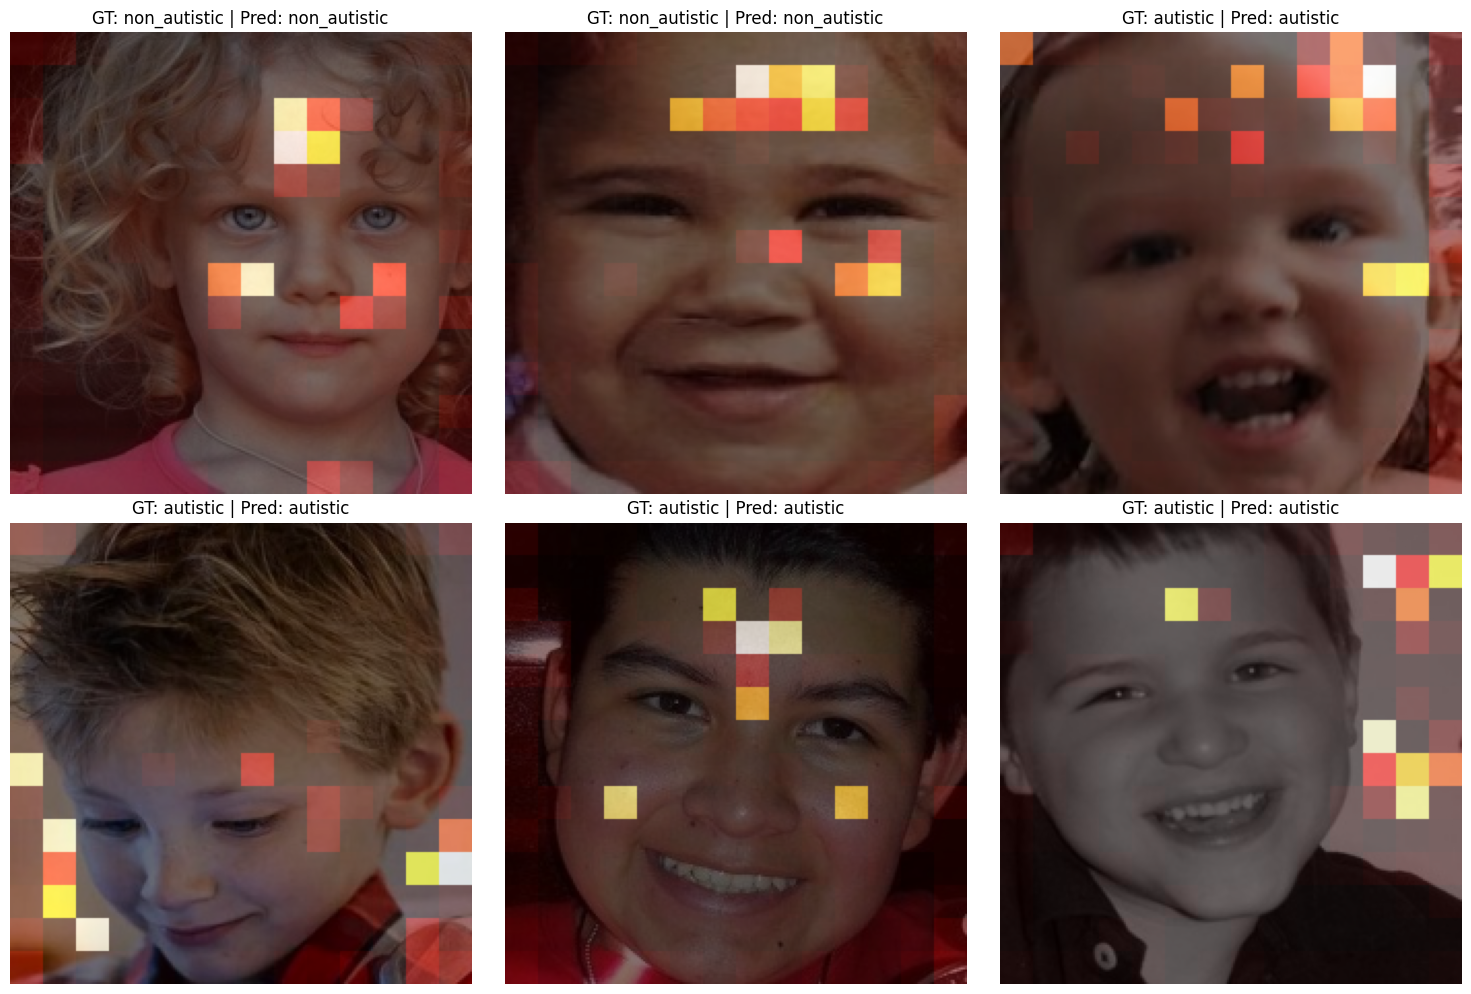

✓ Generated figs/vit_attention_maps.pdf and figs/vit_attention_maps.png for publication Figure 


In [ ]:
#!/usr/bin/env python3
"""
Generate ViT CLS-token Attention Maps for FERAC Dataset
Creates publication-ready Figure: 2x3 grid of images with attention overlays.

Assumptions:
- FERAC folder structure: ./consolidated/{angry,disgust,fear,happy,neutral,sad,surprise}/...
- You saved model weights using: torch.save(model.state_dict(), 'fer_vit_best.pth')
"""

import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18, ResNet18_Weights
from timm.models.vision_transformer import vit_base_patch16_224

# ------------------------------- Config -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_path = "./consolidated"                 # FERAC root folder
checkpoint_path = "fer_vit_best.pth"            # saved state_dict checkpoint
out_dir = "figs"
os.makedirs(out_dir, exist_ok=True)

image_size = 224
patch_size = 16                                  # ViT-B/16 patch size
grid_size = image_size // patch_size             # 224/16 = 14
num_heads = 12                                   # ViT-B/16 uses 12 heads
selected_heads = [1, 3, 7, 11]                   # valid head indices (0..11)

# Pick 6 examples by global test index (after split). Replace as you like.
# These are indices into the TEST subset (not the full dataset).
test_indices = [10, 50, 120, 200, 350, 400]

FERAC_CLASSES = ["autistic", "non_autistic"]

# ------------------------------- Transforms -------------------------------
# Model input normalization (ImageNet)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Inverse transform for visualization (tensor -> displayable image)
inv_transform = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
])

# ------------------------------- Dataset -------------------------------
class FERACDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.classes = FERAC_CLASSES
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_dir):
                raise FileNotFoundError(f"Missing class folder: {cls_dir}")
            for fname in os.listdir(cls_dir):
                fpath = os.path.join(cls_dir, fname)
                if os.path.isfile(fpath) and fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.samples.append((fpath, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label, path  # include path for debugging

# ------------------------------- Model (same as your training) -------------------------------
class FER_ViT(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        # ResNet-18 local features
        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()  # -> (B, 512)

        # ViT global features
        self.vit = vit_base_patch16_224(pretrained=True)  # -> (B, tokens, 768) or (B,768) depending on timm

        # Freeze ResNet except layer3/layer4 (as in your code)
        for name, p in self.backbone.named_parameters():
            p.requires_grad = False
            if ("layer3" in name) or ("layer4" in name):
                p.requires_grad = True

        # ViT trainable (fine-tuned in training)
        for p in self.vit.parameters():
            p.requires_grad = True

        self.feature_fusion = nn.Sequential(
            nn.Linear(512 + 768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        local = self.backbone(x)  # (B,512)

        vit_out = self.vit.forward_features(x)
        # timm compatibility: handle (B,T,768) or (B,768)
        if vit_out.ndim == 3:
            cls_tok = vit_out[:, 0, :]  # (B,768)
        else:
            cls_tok = vit_out           # (B,768)

        fused = self.feature_fusion(torch.cat([local, cls_tok], dim=1))
        logits = self.classifier(fused)
        return logits

# ------------------------------- Attention Capture Patch (timm-safe) -------------------------------
def enable_attention_capture(vit_model):
    """
    Patch the LAST transformer block's attention to store its attention matrix.

    After a forward pass, you can read:
      vit_model.blocks[-1].attn.last_attn  -> (B, heads, tokens, tokens)
    """
    block = vit_model.blocks[-1]
    attn_mod = block.attn
    original_forward = attn_mod.forward

    def forward_with_attn(*args, **kwargs):
        # This re-implements timm Attention forward *just enough* to capture attn,
        # while still using the module's own weights.
        x = args[0]  # (B, tokens, C)
        B, N, C = x.shape

        qkv = attn_mod.qkv(x).reshape(B, N, 3, attn_mod.num_heads, C // attn_mod.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)      # (3, B, heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * attn_mod.scale  # (B, heads, N, N)
        attn = attn.softmax(dim=-1)
        attn_mod.last_attn = attn.detach()                 # store for later visualization

        attn = attn_mod.attn_drop(attn)
        x_out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x_out = attn_mod.proj(x_out)
        x_out = attn_mod.proj_drop(x_out)
        return x_out

    attn_mod.forward = forward_with_attn
    return original_forward  # in case you want to restore

# ------------------------------- Build data split (same as training) -------------------------------
full_dataset = FERACDataset(dataset_path, transform=transform)

total = len(full_dataset)
train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size

train_set, val_set, test_set = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# We will load one image at a time for clean attention maps
test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

# ------------------------------- Load model weights -------------------------------
model = FER_ViT(num_classes=2).to(device)
state = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(state)
model.eval()

# Enable attention capture on last ViT block
_ = enable_attention_capture(model.vit)

# ------------------------------- Utility: overlay attention -------------------------------
def attention_to_image(attn_cls_to_patches: np.ndarray) -> np.ndarray:
    """
    Convert CLS->patch attention (length N_patches) to 224x224 heatmap.
    """
    attn_grid = attn_cls_to_patches.reshape(grid_size, grid_size)  # 14x14
    # Upsample from 14x14 to 224x224 using kron (nearest neighbor)
    heat = np.kron(attn_grid, np.ones((patch_size, patch_size)))
    return heat[:image_size, :image_size]

# ------------------------------- Collect and plot 6 examples -------------------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Convert test_indices to a set for fast lookup
target_set = set(test_indices)
collected = 0

with torch.no_grad():
    for idx, (img, label, path) in enumerate(test_loader):
        if idx not in target_set:
            continue

        img = img.to(device)
        logits = model(img)
        pred = logits.argmax(1).item()
        gt = int(label.item())

        # Read attention from last block (B=1, heads, tokens, tokens)
        attn = model.vit.blocks[-1].attn.last_attn  # (1, heads, N, N)
        attn = attn[0]                              # (heads, N, N)

        # CLS token is position 0; patches are positions 1..N-1
        # Extract CLS -> patches attention, then average across selected heads
        cls_to_patches = attn[selected_heads, 0, 1:].mean(0).cpu().numpy()  # (N_patches,)

        heat = attention_to_image(cls_to_patches)
        heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)       # normalize to [0,1]

        # Prepare image for display (denormalize)
        img_vis = inv_transform(img[0].cpu()).clamp(0, 1)
        img_vis = img_vis.permute(1, 2, 0).numpy()

        ax = axes[collected]
        ax.imshow(img_vis)
        ax.imshow(heat, cmap="hot", alpha=0.55)
        ax.set_title(f"GT: {FERAC_CLASSES[gt]} | Pred: {FERAC_CLASSES[pred]}")
        ax.axis("off")

        collected += 1
        if collected >= 6:
            break

plt.tight_layout()
pdf_path = os.path.join(out_dir, "vit_attention_maps.pdf")
png_path = os.path.join(out_dir, "vit_attention_maps.png")
plt.savefig(pdf_path, bbox_inches="tight", dpi=300)
plt.savefig(png_path, bbox_inches="tight", dpi=300)
plt.show()

print(f"✓ Generated {pdf_path} and {png_path} for publication Figure ")

In [ ]:
import torch

# Assume 'model' is your trained FER_ViT model
checkpoint_path = '/content/drive/MyDrive/autism_project/fer_vit_best.pth'
torch.save(model.state_dict(), checkpoint_path)
print(f"✓ Model weights saved to {checkpoint_path}")



✓ Model weights saved to /content/drive/MyDrive/autism_project/fer_vit_best.pth


In [ ]:
# Rebuild the model architecture first
model = FER_ViT(num_classes=2).to(device)

# Load the saved weights
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()  # put in evaluation mode
print("✓ Model weights loaded successfully")


✓ Model weights loaded successfully
